# Case txp

> In this case study, we are exploring deep learning interpretability on BSI prognosis, before, during and after training a CNN model on multi-variate time series medical record.
 
> we use hourly aggregated physiological data and lab results from 10,000 ICU patients. 1824 positive events and 31496 control group events are generated from the population. 

> we use 25 features selected by domain knowledge, 96 hours prior to the blood culture acquisition to classify positive test results from the control group -- negative test results and 4 days of randomly sliced baseline patient data.  


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import FAIRStream

In [2]:
# csv pool folder directory
csv_pool_path = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/csv_pool'
# current experiment working directory
work_dir = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_fwd'

# initiate dataframe to return
all_df=None
# initiate a FAIRStream object instance for BSI project
bsi_stream = FAIRStream.FAIRStream(work_dir)
# take a look at dictionaries in engineer's hands
#bsi_stream.engineer.csv_source_dict
print(bsi_stream.engineer.variable_dict)
print(bsi_stream.engineer.csv_source_dict)

Success: Querier has initiated a csv source dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_fwd/meta_data/csv_source_dict_demo.json
Success: Querier has initiated a variable dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_fwd/meta_data/variable_dict_demo.json
Unable to read sql source dictionary. Use Querier.update_sql_source_dict() to build one.
{'__uid': {'src_names': ['id', 'ID', 'subject_id', 'subject_id', 'oldid'], 'label': 'subject id', 'unique_per_sbj': True}, '__time': {'src_names': ['tsa', 'timeMinutes'], 'label': 'Time since admission', 'unit': 'minute'}, '__anchor': {'src_names': ['True_positive', 'True positive', 'label'], 'label': 'episode anchor', 'unique_per_sbj': False, 'shuffle': ['__nbc'], 'factor': {'levels': {'__nbc': ['nan'], '__ctm': ['contaminant'], '__neg': ['0', '0.0', 'negative'], '__pos': ['1', '1.0', 'true_positive']}, 'impute_per_sbj': {'nan_level': '__nbc'}}}, 'y': {'output': True, 'src_names': 

In [3]:
# bsi_stream.querier.create_csv_pool(csv_pool_dir = csv_pool_path,
#                                   source_key="uvanewbc",
#                                   file_key="all",
#                                   sep="_")

In [4]:
# bsi_stream.querier.create_csv_pool(csv_pool_dir = csv_pool_path,
#                                   source_key="uvanewnbc",
#                                   file_key="all",
#                                   sep="_")

In [5]:
## nbc (baseline) group 
# # define an episode (notice that the engineer now has new attributes)
# bsi_stream.engineer.DefineEpisode(input_time_len=1*60, # using vital signs and labs 4 days prior to a culture 
#                                   output_time_len=(4*24-1)*60, # predict one time unit into the future
#                                   time_resolution=60, # aggregate minutely data to one row per hour 
#                                   time_lag=0,  # no time lag between predictors and response
#                                   anchor_gap=4*24*60) # the minimum distance between two episodes

In [6]:
## nbc group 
bsi_stream.engineer.DefineEpisode(input_time_len=4*24*60, # using vital signs and labs 4 days prior to a culture 
                                  output_time_len=3*24*60, # predict one time unit into the future
                                  time_resolution=60, # aggregate minutely data to one row per hour 
                                  time_lag=0,  # no time lag between predictors and response
                                  anchor_gap=7*24*60) # the minimum distance between two episodes

Success! Engineer has updated attributes --- episode. 


In [7]:
df_nbc = pd.read_csv("/Users/jiaxingqiu/Documents/CAMA_projects/BSI/2016_2021/data_ml/bsi_new_deidentified_nbc.csv")

In [8]:
len(list(df_nbc['id'].unique()))

23075

In [9]:
id_list = list(df_nbc['id'].unique())[8000:16000]
df_nbc_now = df_nbc.loc[df_nbc.id.isin(id_list),:]

In [10]:
df_nbc_now.shape

(959586, 66)

In [11]:
# Build MVTS dataframe or tfds  (notice that the engineer now has new attributes)
bsi_stream.engineer.BuildMVTS(csv_pool_path, 
                              nsbj = 50, # number of subjects / patients to sample from the pool 
                              replace = False, # sample with replacement or not 
                              valid_frac = 0.2, # fraction of number of subjects in validation dataset
                              test_frac = 0.1, # fraction of number of subjects in left-out test dataset
                              batch_size = 64, # batch size (usually 32,64,128..)
                              impute_input='none', # imputation on predictors
                              impute_output='none',# imputation on response (no need in BSI project)
                              sep="_", 
                              return_episode=True,
                              df_raw=df_nbc_now)


Engineer is sampling without replacement --- 
Just kidding :) Engineer is using external tabular data you input!
-- __time fixed
-- __anchor fixed
-- y fixed
--- fix upper boundary for age by 90.0
--- fix lower boundary for age by 18.03
-- age fixed
--- fix upper boundary for albumin by 4.9
--- fix lower boundary for albumin by 1.2
-- albumin fixed
--- fix upper boundary for alp by 1000.0
--- fix lower boundary for alp by 18.0
-- alp fixed
--- fix upper boundary for alt by 2500.0
--- fix lower boundary for alt by 6.0
-- alt fixed
--- fix upper boundary for ast by 2500.0
--- fix lower boundary for ast by 8.0
-- ast fixed
--- fix upper boundary for bicarbonate by 55.9
--- fix lower boundary for bicarbonate by 5.8
-- bicarbonate fixed
--- fix upper boundary for bun by 150.0
--- fix lower boundary for bun by 2.0
-- bun fixed
--- fix upper boundary for calcium by 13.894550000003099
--- fix lower boundary for calcium by 5.2
-- calcium fixed
--- fix upper boundary for chloride by 137.0
--- fi

/Users/jiaxingqiu/Documents/FAIRStream/FAIRStream/Functions/make_episodes_ts.py:139: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_sbj_ts = pd.concat([df_sbj_ts_event, df_sbj_ts_cntrl], axis=0)


Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3932019.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3932250.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3932727.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3934194.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3934314.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3943743.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3945114.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3945711.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3946287.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3946335.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3960267.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3960639.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3961020.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3961494.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3961785.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3977346.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3977394.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3977475.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3977799.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3978225.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3991041.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3991593.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3992562.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3992712.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_3992976.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4014534.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4016226.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4016289.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4016400.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4017219.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4036272.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4037985.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4039887.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4040391.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4040487.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4054281.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4054482.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4054599.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4055001.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4055106.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4073211.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4074237.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4074762.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4074819.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4074918.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4092192.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4092282.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4092492.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4092786.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4092825.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4107729.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4108332.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4109205.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4109259.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4110114.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4130556.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4130676.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4131078.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4131747.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4131792.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4146441.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4147599.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4147737.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4147770.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4147797.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4169070.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4169289.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4169529.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4170396.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4172079.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4191135.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4192164.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4192545.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4192956.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4193265.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4213200.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4214481.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4214772.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4215540.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4216434.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4229829.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4230666.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4231713.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4231794.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4232256.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4246956.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4247601.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4248447.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4248573.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4248720.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4265868.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4266393.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4267119.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4267947.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4268088.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4284933.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4285014.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4285026.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4285416.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4285596.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4302789.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4303137.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4304844.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4304856.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4305762.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4322112.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4323009.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4323054.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4325280.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4325766.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4346547.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4346904.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4348059.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4348404.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4348575.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4367565.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4367634.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4368333.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4368423.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4368753.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4383135.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4384056.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4384134.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4384746.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4384749.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4399404.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4399551.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4399704.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4400499.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4400517.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4422891.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4423029.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4423134.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4423698.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4423788.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4439178.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4440444.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4441224.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4441884.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4442415.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4461663.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4461810.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4462344.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4462812.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4464174.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4484736.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4485000.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4485060.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4485414.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4486632.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4503555.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4504047.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4504143.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4504287.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4504665.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4522173.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4522674.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4522698.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4522938.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4523310.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4540086.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4540506.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4541460.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4541883.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4542246.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4559061.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4559334.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4559940.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4560321.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4560540.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4579089.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4579107.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4579533.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4580058.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4580211.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4597833.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4597893.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4598250.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4598667.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4598760.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4619958.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4620096.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4620792.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4621497.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4621857.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4635048.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4636386.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4636704.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4637250.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4637301.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4658526.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4658535.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4658784.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4659138.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4659369.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4686513.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4687848.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4688385.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4688538.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4688553.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4714071.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4714092.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4714203.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4714272.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4714341.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4737528.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4737993.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4739088.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4740063.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4741929.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4765041.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4765236.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4765857.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4765956.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4766502.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4782444.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4783317.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4783323.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4783554.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4784058.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4803312.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4804500.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4804692.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4806297.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4807050.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4824240.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4825374.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4826880.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4828536.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4828788.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4847010.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4847601.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4847763.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4848258.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4848486.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4875588.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4877406.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4877799.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4878729.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4879149.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4904361.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4904535.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4904850.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4905009.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4905117.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4929534.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4931877.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4931961.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4932384.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4932864.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4952898.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4953543.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4953588.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4955373.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4956798.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4976103.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4977204.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4977999.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4979598.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4980183.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4998609.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4998636.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4998882.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4998981.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_4999653.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5020413.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5022321.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5022438.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5022552.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5022642.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5037783.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5038788.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5039361.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5040078.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5040237.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5060565.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5060967.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5061093.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5062122.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5062704.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5078385.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5078481.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5080458.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5081187.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5081388.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5101182.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5102055.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5103615.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5104038.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5104302.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5122893.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5123202.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5123955.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5124216.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5124468.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5141091.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5141994.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5142162.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5143041.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5143185.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5165013.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5165817.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5166180.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5166405.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5166966.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5187012.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5188029.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5188032.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5188050.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5188074.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5204598.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5206386.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5206866.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5206980.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5207082.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5225715.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5225850.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5226447.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5226915.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5227386.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5248386.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5248497.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5248626.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5248722.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5249532.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5273655.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5274168.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5274336.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5274810.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5275341.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5293482.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5293563.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5294529.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5294871.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5295513.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5317599.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5318178.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5319036.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5319558.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5319819.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5336946.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5337651.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5337810.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5338416.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5340078.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5366493.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5367105.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5367348.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5368074.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5368206.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5391711.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5391723.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5393037.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5393049.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5394528.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5417163.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5417307.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5417616.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5417790.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5417901.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5436135.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5437551.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5438271.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5438994.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5439117.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5455167.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5455785.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5455887.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5456973.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5457543.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5486043.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5486766.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5486994.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5488044.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5488230.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5510157.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5510661.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5511534.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5511609.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5511711.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5537331.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5537820.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5538825.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5538894.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5538954.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5564361.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5565429.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5566149.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5567034.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5567250.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5586909.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5586981.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5587005.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5587413.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5587818.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5609808.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5611626.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5611731.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5612751.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5613063.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5631429.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5631702.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5633715.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5634744.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5634996.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5658552.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5659335.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5659344.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5659437.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5659983.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5683539.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5684637.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5684910.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5686215.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5686299.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5702409.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5702421.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5702865.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5703009.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5703312.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5731200.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5731230.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5731656.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5734908.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5735430.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5755491.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5756016.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5756208.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5756271.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5756721.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5781669.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5781798.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5781849.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5782230.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5782926.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5806185.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5806497.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5807013.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5807250.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5808546.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5831205.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5831622.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5832213.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5834946.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5835393.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5862996.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5863050.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5863155.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5863302.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5864367.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5887770.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5888349.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5888463.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5889195.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5889270.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5904315.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5905482.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5905869.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5906085.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5907153.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5930901.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5931777.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5931816.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5932272.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5934393.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5960445.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5960829.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5960970.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5961795.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5961885.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5985057.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5985723.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5986278.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5986293.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_5989062.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6016824.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6017232.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6018090.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6019050.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6019179.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6039798.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6040020.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6040683.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6041439.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6041712.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6063408.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6063603.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6064068.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6065028.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6066951.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6086469.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6087390.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6087513.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6088065.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6089460.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6117459.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6117837.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6118011.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6118092.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6120078.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6137451.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6137493.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6137550.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6138045.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6138720.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6159675.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6160410.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6160977.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6161496.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6161538.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6186459.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6186606.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6187398.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6187503.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6188637.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6211776.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6212409.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6212493.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6212589.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6212826.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6232002.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6233136.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6233256.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6233322.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6233529.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6254907.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6254997.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6255198.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6255963.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6256779.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6273951.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6274464.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6275325.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6275343.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6275760.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6296931.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6296973.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6297255.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6297300.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6297747.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6312675.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6313941.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6314667.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6314856.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6315264.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6336294.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6337044.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6337422.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6337578.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6338205.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6357432.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6357585.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6357678.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6357828.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6357993.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6381822.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6382200.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6383370.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6383931.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6384081.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6399126.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6400839.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6401388.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6401532.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6403653.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6432603.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6432969.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6434589.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6435039.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6435525.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6449838.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6451194.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6451254.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6451473.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6451863.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6466563.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6466572.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6467538.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6467757.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6468060.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6487974.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6488514.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6488574.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6488586.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6488781.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6495921.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6495954.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6496077.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6496083.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6496140.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6518478.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6518562.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6518823.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6519621.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6520077.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6538740.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6539034.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6539076.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6540189.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6540381.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6560202.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6560262.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6561324.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6561927.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6562269.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6578802.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6578880.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6579252.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6579432.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6579879.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6595164.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6596553.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6596718.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6596811.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6596916.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6613542.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6613935.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6615654.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6615693.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6615822.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6637716.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6638274.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6638970.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6639948.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6640026.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6657051.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6657225.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6657594.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6657861.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6658143.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6678708.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6680013.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6681201.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6681636.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6681996.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6702795.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6703710.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6705687.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6706773.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6707352.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6733020.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6734538.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6735549.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6735594.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6735693.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6755466.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6755799.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6757128.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6758343.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6758550.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6776736.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6777309.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6777420.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6777915.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6778128.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6798147.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6798831.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6800817.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6801009.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6802305.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6823977.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6823992.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6824106.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6824235.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6825747.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6846264.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6847395.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6847551.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6848040.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6848376.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6872502.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6872757.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6872979.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6873252.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6874263.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6891351.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6891357.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6891639.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6891897.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6893274.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6907407.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6908235.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6908586.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6908598.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6908796.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6929550.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6929676.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6930138.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6930144.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6930318.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6950913.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6951063.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6952947.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6953703.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6953964.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6970986.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6972024.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6972501.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6972723.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6973875.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6995721.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6996069.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6996522.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6996708.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_6998502.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7018773.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7018782.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7019091.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7019388.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7021128.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7041057.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7041468.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7042488.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7042665.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7042806.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7063965.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7064505.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7064700.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7064937.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7065555.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7087068.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7087395.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7088178.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7088412.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7088487.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7107480.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7108656.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7113081.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7114422.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7114497.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7130541.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7131879.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7132269.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7132515.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7132539.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7148190.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7148337.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7148550.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7148781.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7149504.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7165080.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7165086.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7165101.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7165404.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7165464.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7184217.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7184274.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7184712.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7185444.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7186629.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7203162.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7203303.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7204362.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7204434.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7204704.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7222014.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7222179.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7222317.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7222743.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7223148.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7241214.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7241274.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7241751.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7241754.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7242063.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7269177.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7269279.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7269873.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7269933.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7270131.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7285662.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7285770.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7287987.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7288401.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7288461.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7309296.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7309629.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7309989.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7310235.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7311069.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7328484.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7328769.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7328892.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7330284.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7330575.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7345053.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7345653.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7345836.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7346202.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7346979.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7361547.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7361583.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7361748.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7362108.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7362423.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7382136.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7382361.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7382685.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7383057.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7383516.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7401276.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7401309.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7401750.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7402398.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7402941.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7420497.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7420584.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7420860.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7421532.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7421772.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7439133.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7439361.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7439745.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7440369.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7440597.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7452507.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7453233.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7453962.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7453974.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7455366.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7472169.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7472700.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7473462.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7473954.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7474245.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7486164.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7486599.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7486944.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7487325.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7487898.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7502157.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7502664.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7502829.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7503213.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7504224.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7518735.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7518750.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7519365.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7519686.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7521255.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7539249.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7539816.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7540977.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7541901.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7542147.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7553286.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7554000.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7554876.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7555308.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7555362.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7572396.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7572852.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7572939.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7573065.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7573221.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7584705.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7585503.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7585542.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7585656.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7585728.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7603737.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7604265.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7604346.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7604412.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7604478.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7617546.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7618161.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7618338.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7618374.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7618731.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7628967.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7629213.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7629621.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7630218.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7631250.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7642836.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7643157.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7643511.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7644003.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7644159.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7653504.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7653531.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7653684.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7653735.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7653855.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7663113.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7663182.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7663188.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7663194.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7663482.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7672155.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7672248.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7672500.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7672680.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7673022.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7678569.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7678701.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7678794.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7678917.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7678944.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7683975.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7684221.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7684269.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7684311.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7684944.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7691061.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7691499.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7691646.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7691877.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7691880.0
Success! Output/responce variable mean in current sample spa

In [12]:
all_df_new = pd.concat( [bsi_stream.engineer.train_df, bsi_stream.engineer.valid_df], axis=0)
all_df_new = pd.concat( [all_df_new, bsi_stream.engineer.test_df], axis=0)
print(all_df_new.groupby(['txp___yes'])['__uid'].nunique())
if all_df is None:
    all_df = all_df_new
else:
    all_df = pd.concat( [all_df, all_df_new], axis=0)
print(len(set(all_df.__uid))) 

txp___yes
0.0    7622
1.0     378
Name: __uid, dtype: int64
8000


In [13]:
all_df.to_csv("./data_bsi_txp_7d_15_21_nbc_2.csv",index=False)

In [14]:
all_df = pd.read_csv("./data_bsi_txp_4d_17_21_nbc.csv")

In [16]:
all_df.to_csv("./data_bsi_txp_4d_17_21_nbc.csv", index=False)

<AxesSubplot:>

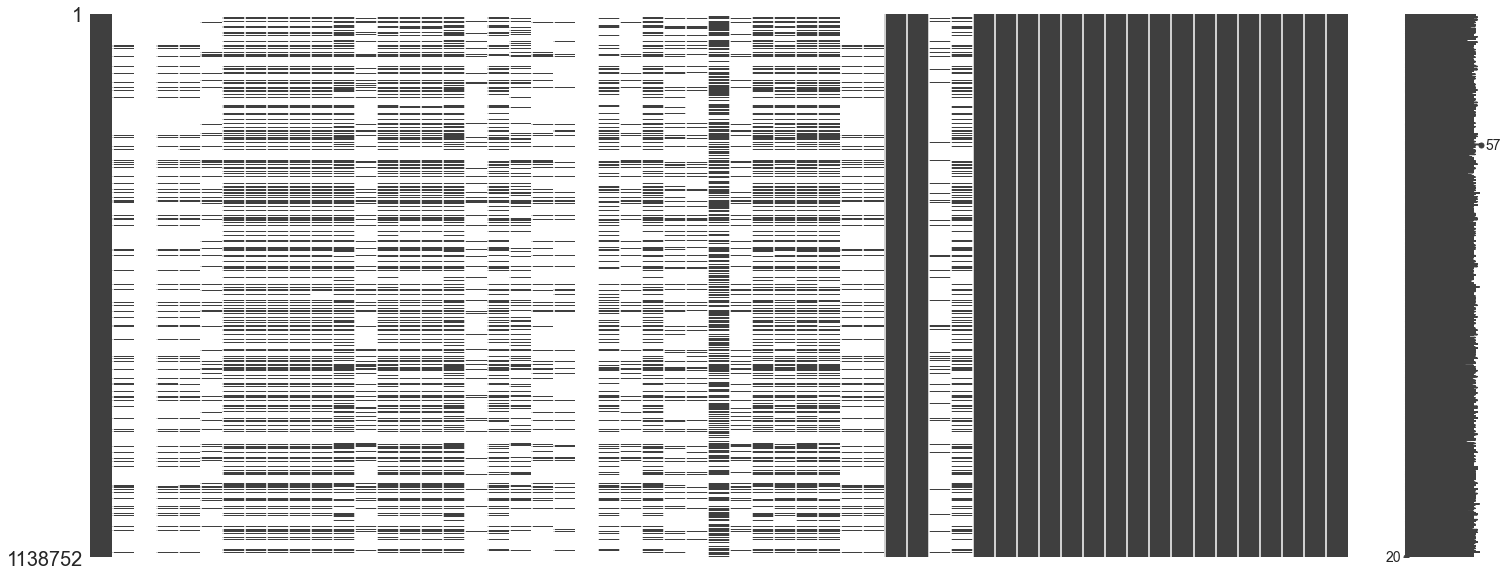

In [10]:
import missingno as msno
msno.matrix(all_df_new)

In [ ]:
bsi_stream.engineer.sbj_df.to_csv("./data_bsi_uva_old_sbj.csv",index=False)

In [ ]:
all_df_new = pd.concat( [bsi_stream.engineer.train_df, bsi_stream.engineer.valid_df], axis=0)
all_df_new = pd.concat( [all_df_new, bsi_stream.engineer.test_df], axis=0)
import missingno as msno
#msno.matrix(all_df_new)

In [ ]:
# nbc
#all_df.to_csv("./data_bsi_txp_4d_nbc.csv",index=False)
# bc
#all_df.to_csv("./data_bsi_txp_4d_bc.csv",index=False)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import FAIRStream

In [ ]:
# csv pool folder directory
csv_pool_path = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/csv_pool'
# current experiment working directory
work_dir = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_txp'

In [ ]:
# initiate a FAIRStream object instance for BSI project
bsi_stream = FAIRStream.FAIRStream(work_dir)
# take a look at dictionaries in engineer's hands
#bsi_stream.engineer.csv_source_dict
bsi_stream.engineer.variable_dict

In [ ]:
# define an episode (notice that the engineer now has new attributes)
bsi_stream.engineer.DefineEpisode(input_time_len=2*24*60, # using vital signs and labs 4 days prior to a culture 
                                  output_time_len=24*60, # predict one time unit into the future
                                  time_resolution=60, # aggregate minutely data to one row per hour 
                                  time_lag=0,  # no time lag between predictors and response
                                  anchor_gap=7*24*60) # the minimum distance between two episodes

In [ ]:
print(bsi_stream.engineer.episode)

In [ ]:
# Build MVTS dataframe or tfds  (notice that the engineer now has new attributes)
bsi_stream.engineer.BuildMVTS(csv_pool_path, 
                              nsbj = 6000, # number of subjects / patients to sample from the pool 
                              replace=False, # sample with replacement or not 
                              valid_frac = 0.2, # fraction of number of subjects in validation dataset
                              test_frac = 0.1, # fraction of number of subjects in left-out test dataset
                              batch_size = 64, # batch size (usually 32,64,128..)
                              impute_input='median', # imputation on predictors
                              impute_output='median',
                              sep="_")# imputation on response (no need in BSI project)
# please see the end of console 
# --- Success! Engineer has updated attributes --- train_df_imputed, valid_df_imputed and test_df_imputed. 
# --- Success! Engineer has updated attributes --- train_tfds, valid_tfds and test_tfds. 

In [ ]:
all_df = pd.concat( [bsi_stream.engineer.train_df, bsi_stream.engineer.valid_df], axis=0)
all_df = pd.concat( [all_df, bsi_stream.engineer.test_df], axis=0)
print(len(set(all_df.__uid)))
all_df.describe()

In [ ]:
from random import randint
import matplotlib.pylab as plt 
import numpy as np
from tensorflow.keras.models import Sequential, Model

def get_feature_maps(model, layer_id, input_image):
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,1,0))




def plot_features_map(input_image_list, 
                      cnn,
                      img_title_list,
                      layer_idx):
    
    nrow = len(layer_idx)
    ncol = len(input_image_list)
    
    fig, ax = plt.subplots(nrow+1, ncol, figsize=(20,20))
    
    for j in range(ncol):
        input_image = input_image_list[j]
        ax[0][j].imshow(input_image[:,:,0].transpose(1,0))
        ax[0][j].set_title(img_title_list[j])
        for i in range(nrow):
            feature_map = get_feature_maps(cnn, layer_idx[i], input_image)
            ax[i+1][j].imshow(feature_map[0,:,:])
            ax[i+1][j].set_title('layer {} - {}'.format(layer_idx[i], cnn.layers[layer_idx[i]].get_config()['name']))

    return

## setup

In [ ]:
# csv pool folder directory
csv_pool_path = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/csv_pool'


# current experiment working directory
work_dir = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case4'

In [ ]:
# initiate a FAIRStream object instance for BSI project
bsi_stream = FAIRStream.FAIRStream(work_dir)
# take a look at dictionaries in engineer's hands
#bsi_stream.engineer.csv_source_dict
bsi_stream.engineer.variable_dict

## Define Episode

In [ ]:
# define an episode (notice that the engineer now has new attributes)
bsi_stream.engineer.DefineEpisode(input_time_len=4*24*60, # using vital signs and labs 4 days prior to a culture 
                                  output_time_len=1, # predict one time unit into the future
                                  time_resolution=60, # aggregate minutely data to one row per hour 
                                  time_lag=0,  # no time lag between predictors and response
                                  anchor_gap=7*24*60) # the minimum distance between two episodes

## Build MVTS (multi-variable time series) data objects
- train_df_imputed, valid_df_imputed and test_df_imputed are dataframes
- train_tfds, valid_tfds and test_tfds are tensorflow datasets

In [ ]:
# # Build MVTS dataframe or tfds  (notice that the engineer now has new attributes)
# bsi_stream.engineer.BuildMVTS(csv_pool_path, 
#                               nsbj = 10, # number of subjects / patients to sample from the pool 
#                               valid_frac = 0.2, # fraction of number of subjects in validation dataset
#                               test_frac = 0.1, # fraction of number of subjects in left-out test dataset
#                               batch_size = 64, # batch size (usually 32,64,128..)
#                               impute_input='median', # imputation on predictors
#                               impute_output='median' )# imputation on response (no need in BSI project)

# # please see the end of console 
# # --- Success! Engineer has updated attributes --- train_df_imputed, valid_df_imputed and test_df_imputed. 
# # --- Success! Engineer has updated attributes --- train_tfds, valid_tfds and test_tfds. 

### print all the attributes of the engineer

In [ ]:
# bsi_stream.engineer.info()

# # extract X, Y numpy array by engineer build-in function
# X_train, Y_train, X_valid, Y_valid, X_test, Y_test = bsi_stream.engineer.ExtractXY()

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], X_valid.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
# X_train = X_train.astype('float32')
# X_valid = X_valid.astype('float32')
# X_test = X_test.astype('float32')

# Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[2])
# Y_valid = Y_valid.reshape(Y_valid.shape[0], Y_valid.shape[2])
# Y_test = Y_test.reshape(Y_test.shape[0], Y_test.shape[2])

# X_all = np.concatenate((X_train, X_valid, X_test), axis=0)
# Y_all = np.concatenate((Y_train, Y_valid, Y_test), axis=0)


In [ ]:
# specify input column names
bsi_stream.engineer.input_vars = ['age___vital', 'age___lab', 'temp___vital', 'heart_rate___vital', 'systolic_blood_pressure___vital', 'diastolic_blood_pressure___vital', 'resp_rate___vital', 'glucose___vital', 'bilirubin___vital', 'potassium___vital', 'albumin___vital', 'calcium___vital', 'wbc___vital', 'creatinine___vital', 'platelet_count___vital', 'alt___vital', 'alp___vital', 'ast___vital', 'paco2___vital', 'chloride___vital', 'troponin___vital', 'ptt___vital', 'lactate___vital', 'bun___vital', 'magnesium___vital']


## --- Pre-modeling Interpretability (raw scale) ---

In [ ]:
X_all = np.load("./X_all.npy")
Y_all = np.load("./Y_all.npy")
X_train = np.load("./X_train.npy")
Y_train = np.load("./Y_train.npy")
X_valid = np.load("./X_valid.npy")
Y_valid = np.load("./Y_valid.npy")
X_test = np.load("./X_test.npy")
Y_test = np.load("./Y_test.npy")

print("X_train shape", X_train.shape)
print("Y_train shape", Y_train.shape)
print("X_valid shape", X_valid.shape)
print("Y_valid shape", Y_valid.shape)
print("X_test shape", X_test.shape)
print("Y_test shape", Y_test.shape)
print("X_all shape", X_all.shape)
print("Y_all shape", Y_all.shape)

X_pos = X_all[Y_all[:,1]==1.0][:,:,:,0]
X_ctrl = X_all[Y_all[:,1]==0.0][:,:,:,0]
print("X_pos shape", X_pos.shape)
print("X_ctrl shape", X_ctrl.shape)


### 1. print a few episode as images

In [ ]:
fig, ax = plt.subplots(1,10,figsize=(20,20))
axes = ax.flatten()
for i in range(10): 
    norm = colors.TwoSlopeNorm(vmin = -np.max(np.abs(X_pos[i])), 
                               vcenter = 0,  # change zero to be not white 
                               vmax = np.max(np.abs(X_pos[i])) )
    axes[i].imshow(X_pos[i], cmap='bwr', norm=norm)
    axes[i].set_title('postive episode {}'.format(i))

fig, ax = plt.subplots(1,10,figsize=(20,20))
axes = ax.flatten()
for i in range(10):
    norm = colors.TwoSlopeNorm(vmin = -np.max(np.abs(X_pos[i])), 
                               vcenter = 0, 
                               vmax = np.max(np.abs(X_pos[i])) )
    axes[i].imshow(X_ctrl[i], cmap='bwr', norm=norm)
    axes[i].set_title('control episode {}'.format(i))

### 2. Visualize Statistical Moments -- Positive VS Control Group

#### Statistic Moment 1 -- mean

In [ ]:
# outlier in image

In [ ]:
X_pos_stat = X_pos.mean(axis=0).transpose((1,0))
X_ctrl_stat = X_ctrl.mean(axis=0).transpose((1,0))
X_all_stat = X_all.mean(axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()

im = ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[0])

im = ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[1])

im = ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[2])


#### Statistic Moment 2 -- std

In [ ]:
X_pos_stat = X_pos.std(axis=0).transpose((1,0))
X_ctrl_stat = X_ctrl.std(axis=0).transpose((1,0))
X_all_stat = X_all.std(axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()
im=ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[0])

im=ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[1])

im=ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[2])


#### Statistic Moment 3 -- skewness

In [ ]:
X_pos_stat = scipy.stats.skew(X_pos, axis=0).transpose((1,0))
X_ctrl_stat = scipy.stats.skew(X_ctrl, axis=0).transpose((1,0))
X_all_stat = scipy.stats.skew(X_all, axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()
im=ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[0])

im=ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[1])

im=ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[2])

#### Statistic Moment 4 -- Kurtosis

In [ ]:
X_pos_stat = scipy.stats.kurtosis(X_pos, axis=0).transpose((1,0))
X_ctrl_stat = scipy.stats.kurtosis(X_ctrl, axis=0).transpose((1,0))
X_all_stat = scipy.stats.kurtosis(X_all, axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()
im=ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[0])

im=ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[1])

im=ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[2])

## --- Modeling interpretation raw scale (CNN) ---

In [ ]:
X_train_2d = X_train[:,:,:,0].reshape(X_train[:,:,:,0].shape[0],-1)
X_valid_2d = X_valid[:,:,:,0].reshape(X_valid[:,:,:,0].shape[0],-1)
Y_train_binary = Y_train[:,1]
Y_valid_binary = Y_valid[:,1]
print(X_train_2d.shape)
print(Y_train_binary.shape)
print(X_valid_2d.shape)
print(Y_valid_binary.shape)

In [ ]:
import sklearn
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='liblinear').fit(X_train_2d, Y_train_binary)

#to check the shape of the coefficient matrix
clf.coef_.shape

In [ ]:
scale = np.max(np.abs(clf.coef_))

p = plt.figure(figsize=(25, 25));
nclasses=1
for i in range(nclasses):
    p = plt.subplot(1, nclasses, i + 1)
    p = plt.imshow(clf.coef_[i].reshape(96, 25).T,
                  cmap=plt.cm.RdBu, vmin=-scale, vmax=scale);
    p = plt.axis('off')
    p = plt.title('positive');

### AUROC for logistic regression

In [ ]:
Y_valid_pred = clf.predict_proba(X_valid_2d)
sklearn.metrics.roc_auc_score(Y_valid_binary, Y_valid_pred[:,1])

### binary setup logistic regression

In [ ]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC'),
    keras.metrics.AUC(name='AUPRC', curve='PR')
]

keras.backend.clear_session()
mdl = keras.models.Sequential([
    keras.layers.Flatten(input_shape=list(X_train.shape)[1:4]),
    keras.layers.Dense(1, activation='sigmoid')
])
mdl.summary()
mdl.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=5)
his = mdl.fit(X_train, Y_train_binary, 
              epochs=50, 
              validation_data=(X_valid,Y_valid_binary), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(X_train, Y_train_binary, 
              epochs=50, 
              validation_data=(X_valid,Y_valid_binary), callbacks=[callback])

### multiple classification setup logistic regression

In [ ]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC', multi_label=True),
    keras.metrics.AUC(name='AUPRC', curve='PR', multi_label=True),
    #keras.metrics.recall(....),
]

keras.backend.clear_session()
mdl = keras.models.Sequential([
    keras.layers.Flatten(input_shape=list(X_train.shape)[1:4]),
    keras.layers.Dense(2, activation='softmax')
])
mdl.summary()
mdl.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=5)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])

In [ ]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC', multi_label=True),
    keras.metrics.AUC(name='AUPRC', curve='PR', multi_label=True),
    keras.metrics.recall(....),
]

keras.backend.clear_session()
mdl = keras.models.Sequential([
    keras.layers.Conv2D(64, 
                        kernel_size=(3,3),
                        activation='relu', 
                        padding='same',
                        input_shape=list(X_train.shape)[1:4]),
    keras.layers.MaxPool2D(pool_size=(1,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, 
                        kernel_size=(3,3),
                        activation='relu', 
                        padding='same'),
    keras.layers.MaxPool2D(pool_size=(1,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(1, 
                        kernel_size=(3,3),
                        activation='relu', 
                        padding='same'),
    keras.layers.MaxPool2D(pool_size=(1,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])
mdl.summary()
mdl.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=5)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])

In [ ]:
X_train_pos_img = X_train[Y_train[:,0]==1.0].mean(axis=0)
X_train_ctrl_img = X_train[Y_train[:,0]==0.0].mean(axis=0)

X_valid_pos_img = X_valid[Y_valid[:,0]==1.0].mean(axis=0)
X_valid_ctrl_img = X_valid[Y_valid[:,0]==0.0].mean(axis=0)

X_all_pos_img = X_all[Y_all[:,0]==1.0].mean(axis=0)
X_all_ctrl_img = X_all[Y_all[:,0]==0.0].mean(axis=0)

plot_features_map(input_image_list=[X_all_pos_img, X_all_ctrl_img,
                                    X_train_pos_img, X_train_ctrl_img, 
                                    X_valid_pos_img, X_valid_ctrl_img],
                  img_title_list=["POS (all)", "CTRL (all)",
                                  "POS (train)", "CTRL (train)", 
                                  "POS (valid)", " CTRL (valid)"],
                  layer_idx=[0,3,6], 
                  cnn=mdl)

## --- Post-Modeling interpretation (raw scale + saliency map) ---

In [ ]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations
def plot_saliency(img_idx):
    grads = visualize_saliency(mdl,
                               "visualized_layer",
                               filter_indices=Y_all[img_idx][0], 
                               seed_input=X_all[img_idx], 
                               backprop_modifier=None,
                               grad_modifier="absolute")
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(X_all[img_idx])
    ax[0].set_title('original img id {}'.format(img_idx))
    ax[1].imshow(grads, cmap='jet')
    ax[1].set_title('saliency - predicted {}'.format(img_idx))

plot_saliency(img_idx = 0)

## --- Pre-training Interpretability (standardized) ---

In [ ]:
X_all = np.load("./X_all.npy")
Y_all = np.load("./Y_all.npy")
X_train = np.load("./X_train.npy")
Y_train = np.load("./Y_train.npy")
X_valid = np.load("./X_valid.npy")
Y_valid = np.load("./Y_valid.npy")
X_test = np.load("./X_test.npy")
Y_test = np.load("./Y_test.npy")

print("X_train shape", X_train.shape)
print("Y_train shape", Y_train.shape)
print("X_valid shape", X_valid.shape)
print("Y_valid shape", Y_valid.shape)
print("X_test shape", X_test.shape)
print("Y_test shape", Y_test.shape)
print("X_all shape", X_all.shape)
print("Y_all shape", Y_all.shape)

X_train = (X_train - X_all.mean(axis=0))/X_all.std(axis=0)
X_valid = (X_valid - X_all.mean(axis=0))/X_all.std(axis=0)
X_all = (X_all - X_all.mean(axis=0))/X_all.std(axis=0)

print("X_train shape", X_train.shape)
print("Y_train shape", Y_train.shape)
print("X_valid shape", X_valid.shape)
print("Y_valid shape", Y_valid.shape)
print("X_all shape", X_all.shape)
print("Y_all shape", Y_all.shape)


X_pos = X_all[Y_all[:,1]==1.0][:,:,:,0]
X_ctrl = X_all[Y_all[:,1]==0.0][:,:,:,0]
print("X_pos shape", X_pos.shape)
print("X_ctrl shape", X_ctrl.shape)


In [ ]:
fig, ax = plt.subplots(1,10,figsize=(20,20))
axes = ax.flatten()
for i in range(10): 
    norm = colors.TwoSlopeNorm(vmin = -np.max(np.abs(X_pos[i])), 
                               vcenter = 0, 
                               vmax = np.max(np.abs(X_pos[i])) )
    axes[i].imshow(X_pos[i], cmap='bwr', norm=norm)
    axes[i].set_title('postive episode {}'.format(i))

fig, ax = plt.subplots(1,10,figsize=(20,20))
axes = ax.flatten()
for i in range(10):
    norm = colors.TwoSlopeNorm(vmin = -np.max(np.abs(X_pos[i])), 
                               vcenter = 0, 
                               vmax = np.max(np.abs(X_pos[i])) )
    axes[i].imshow(X_ctrl[i], cmap='bwr', norm=norm)
    axes[i].set_title('control episode {}'.format(i))

#### Statistic Moment 1 -- mean

In [ ]:
X_pos_stat = X_pos.mean(axis=0).transpose((1,0))
X_ctrl_stat = X_ctrl.mean(axis=0).transpose((1,0))
X_all_stat = X_all.mean(axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()

im = ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[0])

im = ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[1])

im = ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[2])


### Statistic Moment 2 -- std

In [ ]:
X_pos_stat = X_pos.std(axis=0).transpose((1,0))
X_ctrl_stat = X_ctrl.std(axis=0).transpose((1,0))
X_all_stat = X_all.std(axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()
im=ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[0])

im=ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[1])

im=ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[2])

#### Statistic Moment 3 -- skewness

#### Statistic Moment 4 -- Kurtosis